In [1]:
import numpy as np
import pandas as pd

import urllib
#import urllib2
import re
from tqdm import tqdm
import time
import nltk
import sys


#search for tuesday vacancy
url = 'https://www.careforkids.com.au/child-care-centre/bentleigh/3204?'
#url = 'https://www.careforkids.com.au/child-care-centre/kew/3101'
url = 'https://www.careforkids.com.au/child-care-centre/balwyn/3103?day=tue&childAge=1&childAgeUnit=years'
url = 'https://www.careforkids.com.au/child-care-centre/templestowe-lower/3107?day=tue&childAge=1&childAgeUnit=years'
conn = urllib.request.urlopen(url)
web = str(conn.read())

In [2]:
match = re.findall('search-results-item-meta',web)
match

match = re.findall('ribbon vacancy available',web)
match

match = re.findall('Approved Places: (\d+)',web)
match

['60']

In [3]:
sub1 = pd.read_csv('sub1.csv',header = None)

sub1.columns = ['name']
sub1['name'] = sub1['name'].apply(lambda x: re.sub('\xa0', '', x))
sub1['postcode'] = sub1['name'].apply(lambda x: re.findall('\d+',x)[0] if re.findall('\d+',x) else None)
sub1['name'] = sub1['name'].apply(lambda x: re.sub(' \d+', '', x))
sub1['name'] = sub1['name'].apply(lambda x: re.sub(r'\([^)]*\)','',x))
sub1['name'] = sub1['name'].apply(lambda x: x.lower().replace(' ','-'))
sub1['name'] = sub1['name'].apply(lambda x: x[:-1] if x[-1] == '-' else x)
sub1['name'] = sub1['name'].apply(lambda x: x[:-1] if x[-1] == '-' else x)

In [4]:
sub2 = pd.read_csv('sub2.csv')

sub2['name'] = sub2['name'].apply(lambda x: x.lower().replace(' ','-'))

In [5]:
df = pd.concat([sub1,sub2])
df = df.drop_duplicates()
df = df.loc[~df.postcode.isnull()]
df['postcode'] = df['postcode'].astype(int)
df = df.loc[df.postcode<3300]
df.shape

(132, 2)

In [6]:
url_format = 'https://www.careforkids.com.au/child-care-centre/TOWN/POSTCODE?day=tue&childAge=1&childAgeUnit=years'
counts = []
frees = []
seats = []
prices = []
periods = []
for i in tqdm(range(df.shape[0])):
    town = df.name.values[i]
    code = df.postcode.values[i]
    url = url_format.replace('TOWN',town)
    url = url.replace('POSTCODE',str(code))

    conn = urllib.request.urlopen(url)
    web = str(conn.read())
    
    match = re.findall('search-results-item-meta',web)
    if match:
        count = len(match)
    else:
        count = 0
    counts.append(count)

    match = re.findall('ribbon vacancy available',web)
    if match:
        free = len(match)
    else:
        free = 0
    frees.append(free)

    match = re.findall('Approved Places: (\d+)',web)
    if match:
        seat = np.mean(list(map(float,match)))
    else:
        seat = -1
    seats.append(seat)
    
    match = re.findall('waiting period is around <b>(\d+)',web)#waiting period
    if match:
        period = np.mean(list(map(float,match)))
    else:
        period = -1
    periods.append(period)
    
    match = re.findall('\$(\d+)',web)#average price
    if match:
        price = np.mean(list(map(float,match)))
    else:
        price = -1
    prices.append(price)


100%|████████████████████████████████████████| 132/132 [02:48<00:00,  1.65s/it]


In [7]:
df['number_of_cc'] = counts
df['avaliable_cc'] = frees
df['average_seats_per_cc'] = seats

In [8]:
df.to_csv('child_care_summary.csv',index = False)

In [14]:
df = pd.read_csv('child_care_summary.csv')

In [15]:
df.head()

,name,postcode,number_of_cc,avaliable_cc,average_seats_per_cc
0,ashburton,3147,5,1,78.750
1,balwyn,3103,3,0,60.000
2,balwyn-north,3104,2,1,77.000
3,camberwell,3124,8,0,73.125
4,canterbury,3126,1,0,31.000


In [16]:
df = df.drop_duplicates(['postcode','name'])
df.shape

(118, 5)

In [17]:
from matplotlib import pyplot as plt

In [18]:
df['number_of_cc'] = df['number_of_cc'] + (np.random.rand(df.shape[0]) - 0.5)*0.5
df['avaliable_cc'] = df['avaliable_cc'] + (np.random.rand(df.shape[0]) - 0.5)*0.5

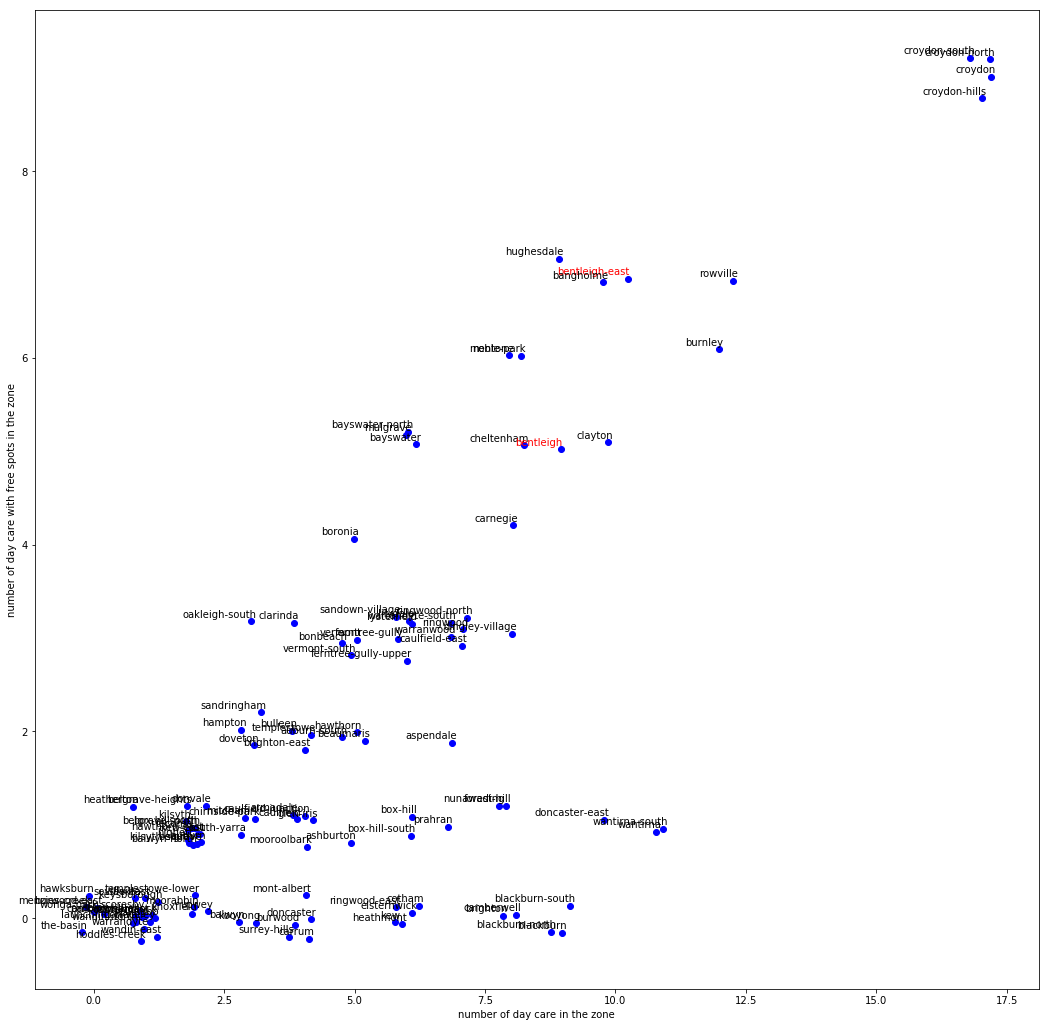

In [28]:
%matplotlib inline
plt.figure(figsize=(18, 18))
colors = ['red','blue','green','yellow']
for i in range(df.shape[0]):
    x, y = df.number_of_cc.values[i], df.avaliable_cc.values[i]
    label = df.name.values[i]
    plt.scatter(x, y, color = 'b')
    if 'bent' in label:
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(2, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                     color = 'red',
                     fontsize = 10
                )
    else:
        plt.annotate(label,
                 xy=(x, y),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom',
                color = 'black',
                 fontsize = 10
                )
plt.xlabel('number of day care in the zone')
plt.ylabel('number of day care with free spots in the zone')
plt.show()